In [2]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

## 1. Lectura información

In [3]:
data_path = r"D:\DANE - Contrato\2024\Operativo Barrido\Data"
emicron = pd.read_csv(data_path + "\EMICRON_VF.csv",header = 0)

C:\Users\carlo\AppData\Local\Temp\ipykernel_53424\2395971023.py:2: DtypeWarning: Columns (59,60,102,104,106,119,132,133,134,135,136,137,140,141,143,157,363,377,388,393,401,420,485,502,503,506,524,525) have mixed types. Specify dtype option on import or set low_memory=False.
  emicron = pd.read_csv(data_path + "\EMICRON_VF.csv",header = 0)


In [4]:
var_estab = ['id','VENTAS_MES_ANTERIOR','CYG','POTTOT','REMUNERACION_TOTAL','COD_DEPTO','CPAM','GRUPOS4','UBICA','IDRUT','CAMCOMER','REG_CONT','ANIOS_OPERACION'] 

var_mov = ['id','VENTAS_MES_ANTERIOR','POTTOT','CYG','COD_DEPTO','CPAM','GRUPOS4','ANOS_ESPACIO','HOMBRE']

var_gral = ['id','CIIU_3','fex','P2760','VA','C_V','k_words','mencion']

In [6]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Outlier', 'Normal')
        return(df)

## 2. Operativo de barrido: establecimientos
Se seleccionarán las unidades económicas de la base de datos que corresponden con viviendas con actividad económica y establecimientos fijos (locales, tienda,  talleres, etc.)  
Por el momento se trabajará únicamente con el año 2022, debido a que la base de 2023 todavía no está completa (hace falta remuneración) 

In [7]:
emicron_estab = emicron[emicron['UBICA']!= 4]
emicron_estab = emicron_estab[emicron_estab['OLA']== 2022]
emicron_estab = emicron_estab[var_estab]
emicron_estab['UBICA'] = emicron_estab['UBICA'].astype(int)
emicron_estab['REG_CONT'] = emicron_estab['REG_CONT'].astype(int)
emicron_estab['IDRUT'] = emicron_estab['IDRUT'].astype(int)
emicron_estab['CAMCOMER'] = emicron_estab['CAMCOMER'].astype(int)
emicron_estab = emicron_estab.reset_index(drop=True)
emicron_estab.shape

(24026, 13)

#### One-hot encoding

In [8]:
emicron_ohe = emicron_estab.copy()

ohe_dpto = OneHotEncoder().fit(emicron_ohe[['COD_DEPTO']])
drop_enc = ohe_dpto.transform(emicron_ohe[['COD_DEPTO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_dpto.get_feature_names_out())


emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_ubi = OneHotEncoder().fit(emicron_ohe[['UBICA']])
drop_enc = ohe_ubi.transform(emicron_ohe[['UBICA']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_ubi.get_feature_names_out())
drop_enc_df.drop('UBICA_3', axis=1, inplace = True)  

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_sector = OneHotEncoder().fit(emicron_ohe[['GRUPOS4']])
drop_enc = ohe_sector.transform(emicron_ohe[['GRUPOS4']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_sector.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_conta = OneHotEncoder().fit(emicron_ohe[['REG_CONT']])
drop_enc = ohe_conta.transform(emicron_ohe[['REG_CONT']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_conta.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

In [9]:
emicron_ohe.drop(['COD_DEPTO','UBICA','GRUPOS4','REG_CONT'],axis=1, inplace= True) 
emicron_ohe.set_index('id',inplace = True, drop = True)

In [10]:
emicron_ohe.shape

(24026, 41)

In [11]:
# Parameters
k_sam = [256, 500, 700, 1000]
k_tree = [100,200,500,1000]

#Almacenar los resultados
iscores_mult = np.zeros([emicron_ohe.shape[0], (len(k_sam)*len(k_tree))])

i = 0

for sam in k_sam:
    for n_tree in k_tree:
        ifo = IsolationForest(random_state = 123,
                              contamination=0.1,
                              max_features= 25,
                              verbose=1,
                              n_jobs=-1,
                              max_samples= sam,
                              n_estimators= n_tree)
        ifo.fit(emicron_ohe)
        # Cálculo del puntaje de atipicidad promedio: valores más bajos representas mayor atipicidad
        iscores_mult[:, i] = ifo.decision_function(emicron_ohe)
        i +=1

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.3s remaining:   10.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


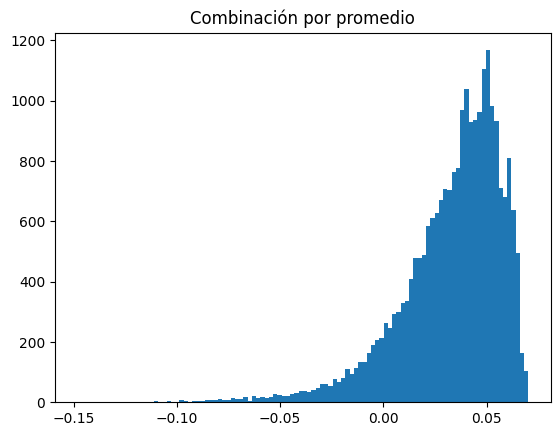

In [12]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_by_average = np.mean(iscores_mult,axis=1)
plt.hist(Y_by_average, bins = 'auto')
#plt.xlim(4.2, 8)
plt.title("Combinación por promedio")
plt.show()

In [13]:
threshold = np.percentile(Y_by_average, 10)
threshold

0.0005809370222526859

In [20]:
iforest_res = descriptive_stat_threshold(emicron_estab, Y_by_average, threshold, 2)

In [22]:
iforest_res = pd.merge(iforest_res,emicron[var_gral], on = 'id', how = 'left')
iforest_res.shape

(24026, 22)

In [23]:
iforest_res.head()

,id,VENTAS_MES_ANTERIOR,CYG,POTTOT,REMUNERACION_TOTAL,COD_DEPTO,CPAM,GRUPOS4,UBICA,IDRUT,...,ANIOS_OPERACION,Anomaly_Score,Group,CIIU_3,fex,P2760,VA,C_V,k_words,mencion
0,212002411,2000000.0,1110000.0,1.0,0.0,8,0,4,1,0,...,0.0,0.032510,Normal,5611.0,122.952097,b'SE TOMA PUNTO DE GEORREFERENCIACION LUGAR DE...,890000.0,0.555000,[],False
1,212003711,1950000.0,1152000.0,1.0,0.0,8,0,4,3,0,...,9.0,0.046885,Normal,5613.0,132.915712,NaN,798000.0,0.590769,NaN,NaN
2,212003812,5600000.0,4200000.0,2.0,400000.0,8,0,4,3,0,...,5.0,0.022973,Normal,5611.0,124.146742,b'NO SUMINISTRO NUMERO DE CEDULA',1400000.0,0.750000,[],False
3,212005411,0.0,0.0,1.0,0.0,8,0,4,3,0,...,6.0,0.038343,Normal,5611.0,148.309512,b'SUSPENDIO LA ACTIVIDAD PORQUE NO TENIA CAPIT...,0.0,0.000000,['insumos'],True
4,212007611,2940000.0,2090000.0,2.0,0.0,8,0,3,3,0,...,0.0,0.038606,Normal,4711.0,29.368199,b'LOS COSTOS QUE ASUMIO EN EL 2021 FUE MENOS P...,850000.0,0.710884,['costo'],True


In [24]:
iforest_res.to_csv(data_path + r"\atipicos_emicron_fijo_iforest.csv", index = False)

## 3. Operativo de barrido: vendedores de calles
Se seleccionarán las unidades económicas de la base de datos que corresponden con puestos móviles.

In [5]:
emicron_mov = emicron[emicron['UBICA']== 4]
emicron_mov = emicron_mov[var_mov]
emicron_mov['CPAM'] = emicron_mov['CPAM'].astype(int)
emicron_mov['COD_DEPTO'] = emicron_mov['COD_DEPTO'].astype(int)
emicron_mov['GRUPOS4'] = emicron_mov['GRUPOS4'].astype(int)

emicron_mov = emicron_mov.reset_index(drop=True)
emicron_mov.shape

(17812, 9)

In [47]:
len(emicron_mov.loc[(emicron_mov == 99).any(axis=1),'id'])

574

In [46]:
emicron[emicron['id'].isin(emicron_mov.loc[(emicron_mov == 99).any(axis=1),'id'])]['OLA'].value_counts()

2023    574
Name: OLA, dtype: int64

In [52]:
emicron['OLA'][emicron['UBICA']==4].value_counts()

2022    9165
2023    8647
Name: OLA, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17812 entries, 0 to 17811
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   17812 non-null  int64  
 1   VENTAS_MES_ANTERIOR  17812 non-null  float64
 2   POTTOT               17812 non-null  float64
 3   CYG                  17812 non-null  float64
 4   COD_DEPTO            17812 non-null  int32  
 5   CPAM                 17812 non-null  int32  
 6   GRUPOS4              17812 non-null  int32  
 7   ANOS_ESPACIO         17812 non-null  float64
 8   HOMBRE               17812 non-null  float64
dtypes: float64(5), int32(3), int64(1)
memory usage: 1.0 MB


#### One-hot encoding

In [ ]:
emicron_ohe = emicron_mov.copy()

ohe_dpto = OneHotEncoder().fit(emicron_ohe[['COD_DEPTO']])
drop_enc = ohe_dpto.transform(emicron_ohe[['COD_DEPTO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_dpto.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_sector = OneHotEncoder().fit(emicron_ohe[['GRUPOS4']])
drop_enc = ohe_sector.transform(emicron_ohe[['GRUPOS4']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_sector.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_anio = OneHotEncoder().fit(emicron_ohe[['ANOS_ESPACIO']])
drop_enc = ohe_anio.transform(emicron_ohe[['ANOS_ESPACIO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_anio.get_feature_names_out())

emicron_ohe = emicron_ohe.join(drop_enc_df)

In [ ]:
emicron_ohe.drop(['COD_DEPTO','GRUPOS4','ANOS_ESPACIO'],axis=1, inplace= True) 
emicron_ohe.set_index('id',inplace = True, drop = True)

In [ ]:
# Parameters
k_sam = [256, 500, 800, 1000]
k_tree = [100,250, 500,1000]

#Almacenar los resultados
iscores_mult = np.zeros([emicron_ohe.shape[0], (len(k_sam)*len(k_tree))])

i = 0

for sam in k_sam:
    for n_tree in k_tree:
        ifo = IsolationForest(random_state = 123,
                              contamination=0.1,
                              max_features= 34,
                              verbose=1,
                              n_jobs=-1,
                              max_samples= sam,
                              n_estimators= n_tree)
        ifo.fit(emicron_ohe)
        iscores_mult[:, i] = ifo.decision_function(emicron_ohe)
        i +=1

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.8s remaining:    5.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


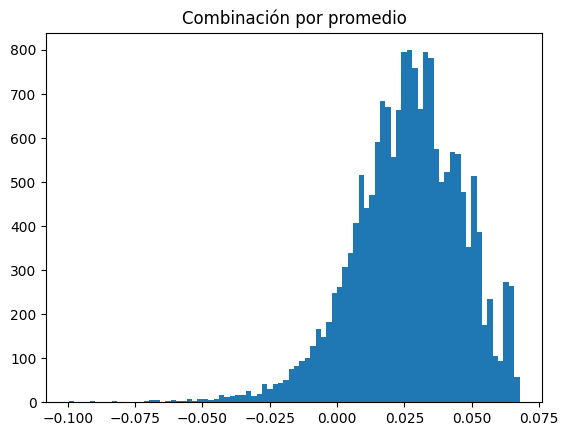

In [ ]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_by_average = np.mean(iscores_mult,axis=1)
plt.hist(Y_by_average, bins = 'auto')
#plt.xlim(4.2, 8)
plt.title("Combinación por promedio")
plt.show()

In [ ]:
threshold = np.percentile(Y_by_average, 10)
threshold

0.0008928128736556571

In [ ]:
iforest_res = descriptive_stat_threshold(emicron_mov, Y_by_average, threshold, 2)

In [ ]:
iforest_res = pd.merge(iforest_res,emicron[var_gral], on = 'id', how = 'left')
iforest_res.shape

(17812, 18)

In [ ]:
iforest_res.to_csv(data_path + r"\atipicos_emicron_vcalle_iforest.csv", index = False)

In [ ]:
iforest_res.head()

,id,VENTAS_MES_ANTERIOR,POTTOT,CYG,COD_DEPTO,CPAM,GRUPOS4,ANOS_ESPACIO,HOMBRE,Anomaly_Score,Group,CIIU_3,fex,P2760,VA,C_V,k_words,mencion
0,212002612,1200000.0,1.0,420000.0,8,0,3,1.0,1.0,0.014638,Normal,4722.0,182.474123,b'CEDULA VENEZOLANA',780000.0,0.350000,[],False
1,212005312,3600000.0,1.0,2690000.0,8,0,3,5.0,1.0,0.038989,Normal,4723.0,83.988234,NaN,910000.0,0.747222,NaN,NaN
2,212017711,7000000.0,2.0,4919000.0,8,0,2,5.0,1.0,-0.031211,Outlier,3830.0,27.296509,NaN,2081000.0,0.702714,NaN,NaN
3,212020112,0.0,1.0,0.0,8,0,3,2.0,0.0,0.013575,Normal,4723.0,45.297531,b'NO DESARROLLO LA ACTIVIDAD EN EL MES DE REFE...,0.0,0.000000,[],False
4,212020612,9000000.0,1.0,7915000.0,8,0,3,5.0,0.0,-0.002637,Outlier,4723.0,30.029363,NaN,1085000.0,0.879444,NaN,NaN


In [ ]:
iforest_res['Group'].value_counts()

Normal     16030
Outlier     1782
Name: Group, dtype: int64